## A Simple Bellman Equation in Continous Time Example:

### 1.Setting

- The Objective Function:
$$ U(t) = \int_t^T e^{-\rho [\tau - t]} \frac{c^{1-\sigma}-1}{1-\sigma} d\tau $$

- The budget constraints:
$$ \dot{a}(\tau) = r(\tau) a(\tau) + w(\tau) - c(\tau) $$

> From Chapter 5, AIO, Example 5.1

### 2. The iteration functions:
- Bellman Equation:
$$ \rho V(k) = max \left\{\frac{c^{1-\sigma}-1}{1-\sigma} + \frac{dV}{da} f(a)\right\}  = max \left\{\frac{c^{1-\sigma}-1}{1-\sigma} + \frac{dV}{da} (r \cdot a + w - c)\right\}$$

- F.O.C:
$$ u'(c) = c^{-\sigma} = \frac{dV}{da} $$

In [1]:
%reset -f
%clear

In [2]:
import numpy as np
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as sparse
import math
from matplotlib.pyplot import cm

### Deterministic Situation

----

In [3]:
###############################################################################################################
# Goal:
#     This Program aims to solve the deterministic benchmark optimal saving problem with Dynamic Programming
#
# Methodology:
#    The methodology used here is value function iteration and the implicit finite difference method
#
# The PDE Equations to solve:
#    1. rho*V(a) = max{u(c) + (ra + w - c)*(dV/da)}
#    2. u'(c) = dV/da
#    here, u(c) = (c^{1-sigma}-1)/(1-sigma)
#
# Structure:
#    The codes have following parts:
#        Part 1: define necessary functions
#        Part 2: define the upwind derivative, i.e., dV/dk
#        Part 3: caluclate the optimal value function by iteration
#        Part 4: plot the value and policy functions under different parameters
#        Part 5: compare the numerical results with analytical results
#
###############################################################################################################

########################################## Part 1: Function Defining ##########################################

## Utility Function
def Utility(c):
    
    '''
        utility function, given different consumption levels, give out the utility level
        Input:
            c: consumption, n * 1 vector (type: np.ndarray)
        Output:
            utility: utility, n * 1 vector (type: matrix)
    '''
    utility = np.zeros(c.size)
    utility = (c**(1-sigma)-1)/(1-sigma)
    utility = np.mat(utility).T
    
    return utility

########################################## Part 2: Upwind Derivative ##########################################

def upwind_d(x_grid,v):
    
    '''
        upwind derivative of given value function
        Inputs:
            x_gird: the gird of the asset levels, n * 1 vector (type: np.ndarray)
            v: the value function, n * 1 vector (type: np.ndarray)
        Output:
            u_c: utility, n * 1 vector (type: np.ndarray)
            f_x_f, f_x_b: forward, backward savings, n * 1 vector, (type: np.ndarray)
            cons: consumption, n * 1 vector, (type: np.ndarray)
            Dv_upwind: dV/da, n * 1 vector, (type: np.ndarray)
    '''
    
    V = v
    
   # Initialize the forward derivative, Dv_f, the backward derivative, Dv_b, the consumption level, c,

    num_x = len(x_grid)
    Dv_f = np.zeros(num_x)
    Dv_b = np.zeros(num_x)
    cons = np.zeros(num_x)
    
    # Update the forward, backward, stable state derivative of value function: dV/dx_f,dV/dx_b,dV/dx_ss, 
    
    for i in range(0, num_x-1):
        Dv_f[i] = (V[i+1] - V[i])/x_h  # calculate the forward derivative by linearization
        
    Dv_f[num_x-1] = 1/ (r*x_max + w)**sigma    # calculate the endpoint of forward derivative,
                                       # use the F.O.C.
                                       # assume the value is the steady state value
    
    for i in range(1, num_x):
        Dv_b[i] = (V[i] - V[i-1])/x_h  # calculate the backward derivative by linearization
        
    Dv_b[0] = 1/(r*x_min + w)**sigma   # calculate the endpoint of backward derivative,
                                       # use the F.O.C.
                                       # assume the value is the steady state value
    
    # Calculate the consumption, the critic condition, the corresponding f(x)
    
    cons_f = np.zeros(num_x)
    cons_f = Dv_f**(-1/sigma) 
                                      # use the F.O.C to calculate the consumption under the forward situation
    f_x_f = r * x_grid + w - cons_f   # calculate the f(x) under the forward situation
    
    cons_b = np.zeros(num_x)
    cons_b = (Dv_b)**(-1/sigma) 
                                      # use the F.O.C to calculate the consumption under the backward situation
    f_x_b = r * x_grid + w - cons_b   # calculate the f(x) under the backward situation    
    
    cons_ss = np.zeros(num_x)
    cons_ss = r * x_grid + w          # calculate the consumption under steady state
    Dv_ss = cons_ss**-sigma        # calculate the dV/dx under steady state

    # combining the dV/dx_f,_b,_ss to upwind dV/dx
    
    Dv_upwind = np.zeros(num_x)
    for i in range(0,num_x):
        weight = np.array([0,0,0])
        if f_x_f[i] > 0:
            weight[0] = 1
        
        if f_x_b[i] < 0:
            weight[1] = 1
        
        if weight[0] == 0 and weight[1]==0:
            weight[2] = 1
            
        Dv_upwind[i] = weight[0] * Dv_f[i] +weight[1] * Dv_b[i] + weight[2] * Dv_ss[i]
                    
    # Calculate the consumption and f(x) with upwind derivative of value function
    
    cons = Dv_upwind**(1/-sigma)

    u_c = np.zeros(num_x)
    u_c = (cons**(1-sigma)-1)/(1-sigma)
    
    return [u_c, f_x_f, f_x_b,cons, Dv_upwind]

##################################### Part 3: Iteration of Value Function #####################################

# One-step update
def update_v(x_grid, v):
    
    '''
        This function aims to solve the following equation, which gives out one-step updating of value function
        
            [(1/D + rho)I - A(n)] V(n+1) = U(n) - V(n)/D
                - D: the step length
                - rho: the subjective discount rate
                - A(n): n-th step A matrix, which forms by forward and backward saving and grid width of assets
                - U(n): n-th step utility
                - V(n), V(n+1): n-th and (n+1)-th value function
        Input:
            x_gird: the gird of the asset levels, n * 1 vector (type: np.ndarray)
            v: the value function, n * 1 vector (type: np.ndarray)
        Outputs:
            v_delta: difference between value function in n-th and (n+1)-th step, n * 1 vector (type: np.ndarray)
            v: updated value function, n * 1 vector (type: np.ndarray)
            upwind_d(x_grid, v)[3]
            upwind_d(x_grid, v)[4]
    '''
    #Calculate the A matrix
    
    f_x_b = np.zeros((num_x,2))
    f_x_b[:,0] = upwind_d(x_grid, v)[2]
    f_x_f = np.zeros((num_x,2))
    f_x_f[:,0] = upwind_d(x_grid, v)[1] 
      
    X = -np.min(f_x_b,axis = 1 )/x_h                              # 1st elements in the row vector
    Y = -np.max(f_x_f,axis = 1)/x_h + np.min(f_x_b, axis = 1)/x_h  # 2nd element in the row vector
    Z = np.max(f_x_f,axis = 1)/x_h                                # 3rd element in the row vector
    
    A = np.zeros((num_x, num_x))
    for i in range(1,num_x-1):
        A[i,i-1] = X[i]
        A[i,i] = Y[i]
        A[i,i+1] = Z[i]
        
    A[0,0]=Y[0]
    A[0,1]=Z[0]
    A[num_x-1,num_x-1] = Y[num_x-1]
    A[num_x-1,num_x-2] = X[num_x-1]
    
    # Set the length of step
    Delta = 1000
    
    # Calculate the LHS of (*), the coefficient of v^{n+1} 
    L = np.identity(num_x)
    L = (rho + 1/Delta) * L - A
    
    # Calculate the RHS of (*) 
    R = np.zeros(num_x)
    R = upwind_d(x_grid, v)[0] + v/Delta;
    
    # update the new value function
    v_new = np.zeros(num_x)
    v_new = np.linalg.inv(L).dot(R)
    
    v_delta = v_new - v
    v_delta = np.absolute(v_delta)
    v = v_new   
    return [v_delta, v, upwind_d(x_grid, v)[3], upwind_d(x_grid, v)[4]]


# Calculate the value function by iteration
def FDM_OS(x_grid, rho, r, w, sigma):
    
    '''
        Value function iteration
        Parameters:
            rho: subject discount rate, scaler
            r: interest rate, scaler
            w: wage, scaler
            sigma: CRRA parameter, scaler
        Inputs:
            x_gird: the gird of the asset levels, n * 1 vector (type: np.ndarray)     
        Outputs:
            v: value function, n * 1 vector (type: np.ndarray)
            cons: policy function, n * 1 vector (type: np.ndarray)
    '''

    ## Set the initial value function:
    
    num_x = len(x_grid)
    v = np.ones(num_x)   
    for i in range(0,num_x):
        v[i] = ((r*x_grid[i]+w)**(1-sigma)-1)/(1-sigma)           
        # assume the initial state is the steady state
        
    ## initial iteratin times and critical value
    itera = 0               # The iteration times
    metric_v = 100          # The metric between new and old value function
    
    # iteration
    while metric_v > 0.001:
        if itera < 5000:
            metric_v = np.max(update_v(x_grid, v)[0])
            v = update_v(x_grid, v)[1]
            itera = itera + 1
            #print(itera, metric_v)
        else:
            break
            
#     Dv_Dx = np.zeros(num_x)
#     Dv_Dx = update_v(x_grid, v)[3]
    
#     cons = 1/Dv_Dx ** sigma  ! wrong formula
    cons = update_v(x_grid, v)[2]
    return [v, cons]

################################# Part 4: plot the value and policy functions #################################   

# plot the value function
def plot_result(I, text):
    color = cm.rainbow(np.linspace(0, 1, I))
    
    fig = plt.figure(figsize = (15,5))
    ax1 = plt.subplot(1,3,1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(min(v), max(v))
    
    plt.xlabel('Asset, State Variable')
    plt.ylabel('Value')
    plt.title('Value Function')


    # plot the phase graph
    
    ax2 = plt.subplot(1,3,2)   
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(min(x_dot), max(x_dot))
    
    plt.xlabel('Asset, State Variable')
    plt.ylabel('Changes of Assets')
    plt.title('Phase Graph')

    # plot the consumption
    
    ax3 = plt.subplot(1,3,3)
    ax3.set_xlim(x_min, x_max)
    ax3.set_ylim(min(cons), max(cons))
    
    plt.xlabel('Asset, State Variable')
    plt.ylabel('Consumption')
    plt.title('Consumption')
    
    for i in range(I):
        ax1.plot(x_grid, v_store[:,i], color = color[i], label = text[i])
        ax1.legend()
        ax2.plot(x_grid, x_dot_store[:,i], color = color[i], label = text[i])
        ax2.legend()
        ax3.plot(x_grid, cons_store[:,i], color = color[i], label = text[i])
        ax3.legend()
        plt.savefig('ogmdtsigma.pdf')
    plt.show()

### Results: Change $\rho$ from 0.1 to 0.9

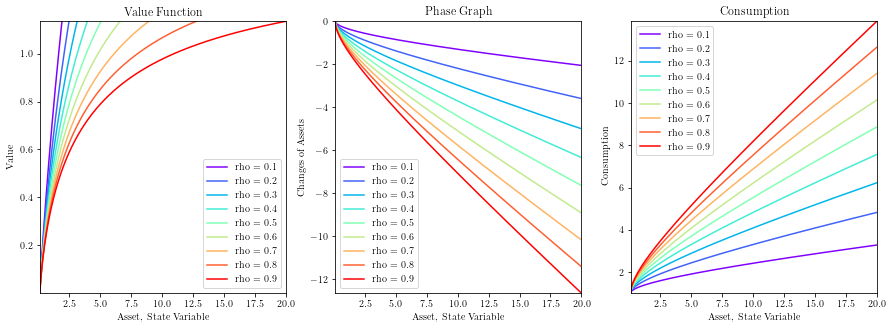

In [4]:
## Initialization Part:
#  Parameters
I = 9
Rho = np.linspace(0.1,0.9,I)
R = np.linspace(0.01,0.02,I)
w = 1
Sigma = np.linspace(1.5,3.5,I)

#  Assest Grid
x_min = 0.1                             # The minimum value of asset
x_max = 20                             # The maximum (allowed) value of asset
x_h = 0.01                               # The width of each cell of the asset grid
num_x = int((x_max - x_min)/x_h) + 1    # The number of the asset grid's nodes 
x_grid = np.linspace(x_min, x_max, num_x, endpoint = True) # the gird is [0.1,0.2 ... 20], all 201 terms

## Results:

r = R[1]
sigma = Sigma[1]

v_store = np.zeros([num_x, I])
cons_store = np.zeros([num_x, I])
x_dot_store = np.zeros([num_x, I])

for i in range(0,I):
    rho = Rho[i]
    cons = FDM_OS(x_grid=x_grid, rho = rho, r = r, w = w, sigma = sigma)[1]
    v = FDM_OS(x_grid=x_grid, rho = Rho[i], r = r, w = w, sigma = sigma)[0]
    x_dot = r * x_grid + w - cons
    
    x_dot_store[:,i] = x_dot
    v_store[:,i] = v
    cons_store[:, i] = cons

text = ['rho = '+ str(round(x,2)) for x in Rho[range(I)]]
plot_result(I,text)

### Results: Change $r$ from 0.01 to 0.02

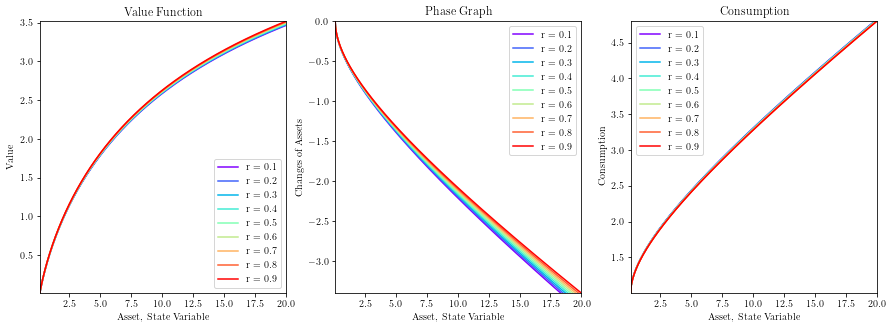

In [5]:
rho = Rho[1]
#r = R[1]
sigma = Sigma[1]

v_store = np.zeros([num_x, I])
cons_store = np.zeros([num_x, I])
x_dot_store = np.zeros([num_x, I])

for i in range(0,I):
    r = R[i]
    cons = FDM_OS(x_grid=x_grid, rho = rho, r = r, w = w, sigma = sigma)[1]
    v = FDM_OS(x_grid=x_grid, rho = Rho[i], r = r, w = w, sigma = sigma)[0]
    x_dot = r * x_grid + w - cons
    
    x_dot_store[:,i] = x_dot
    v_store[:,i] = v
    cons_store[:, i] = cons

text = ['r = '+ str(round(x,2)) for x in Rho[range(I)]]
plot_result(I,text)

### Results: Change $\sigma$ from 0.1 to 0.9

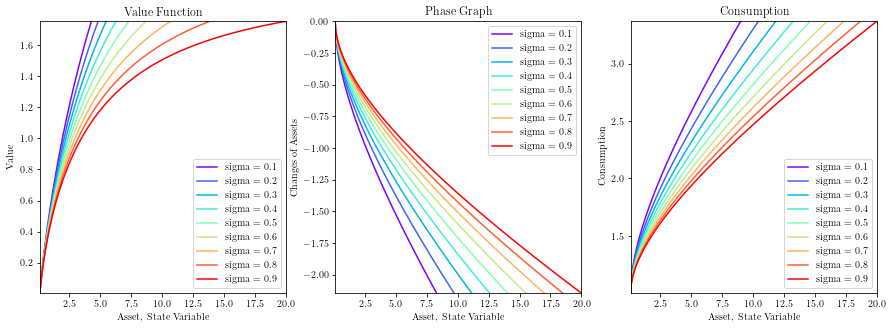

In [6]:
## Results:

rho = Rho[1]
r = R[1]
#sigma = Sigma[1]

v_store = np.zeros([num_x, I])
cons_store = np.zeros([num_x, I])
x_dot_store = np.zeros([num_x, I])

for i in range(0,I):
    sigma = Sigma[i]
    cons = FDM_OS(x_grid=x_grid, rho = rho, r = r, w = w, sigma = sigma)[1]
    v = FDM_OS(x_grid=x_grid, rho = Rho[i], r = r, w = w, sigma = sigma)[0]
    x_dot = r * x_grid + w - cons
    
    x_dot_store[:,i] = x_dot
    v_store[:,i] = v
    cons_store[:, i] = cons

text = ['sigma = '+ str(round(x,2)) for x in Rho[range(I)]]
plot_result(I,text)    


In [7]:
################################## Part 5: Comparing with Analytical Solution #################################

# Consumption path of the analytical solution
def ana_c(c0,T):
    
    '''
        Simulating the optimal consumption path given the initial period's consumption c0 and time periods T
        The optimal conusmption path is as follows:
            c(t) = c0 * e^{(r-rho)t/sigma} 
        Inputs:
            c0: consumption in Period 0, scaler
            T: simulation period, scaler
    '''
    
    # initialize the consumption
    c = np.zeros([T+1])
    c[0] = c0
    
    for i in range(T):
        c[i+1] = c[i] * (1 + (r - rho)/sigma)
        print(c[i+1])
    
    return c
    
# Consumption path of numerical solution
def cc_mapping(c):
    
    '''
        Based on the policy function and motion law of asset, construct a mapping from consumptions in this period to
        that in the next period
        Input:
            c: consumption, scaler
        Output:
            c_pri: consumption in the next period, scaler
    '''
    c_pri = 0
    index_ca = np.where(cons >= c)
    upper = (cons[index_ca[0][0]] - c)/(cons[index_ca[0][0]] - cons[index_ca[0][0]-1])
    a = x_grid[index_ca[0][0]] * upper +  x_grid[index_ca[0][0]-1] * (1-upper)
    xdot = x_dot[index_ca[0][0]] * upper +  x_dot[index_ca[0][0]-1] * (1-upper)
    a = a + xdot
    index_a = np.where(x_grid >= a)
    upper_c = (x_grid[index_a[0][0]] - a)/(x_grid[index_a[0][0]] - x_grid[index_a[0][0]-1])
    c_pri = cons[index_a[0][0]] * upper_c +  cons[index_a[0][0]-1] * (1-upper_c)
    print(index_ca[0][0],xdot,a, c_pri)
    
    return c_pri

def numer_c(c0, T, cons, x_dot, x_grid):
    
    '''
        Simulating the optimal consumption path given the initial period's consumption c0 and time periods T
        Inputs:
            c0: consumption in Period 0, scaler
            T: simulation period, scaler     
            cons: policy function, mappings between asset levels and optimal consumptions, n * 1 vector
            x_dot: savings, mapping betwwen asset level and asset changes, n * 1 vector
            x_gird: the gird of the asset levels, n * 1 vector (type: np.ndarray) 
    '''
    
    c = np.zeros([T+1])
    c[0] = c0
    
    for t in range(T):
        c[t+1] = cc_mapping(c[t])
        
    return c
        
    

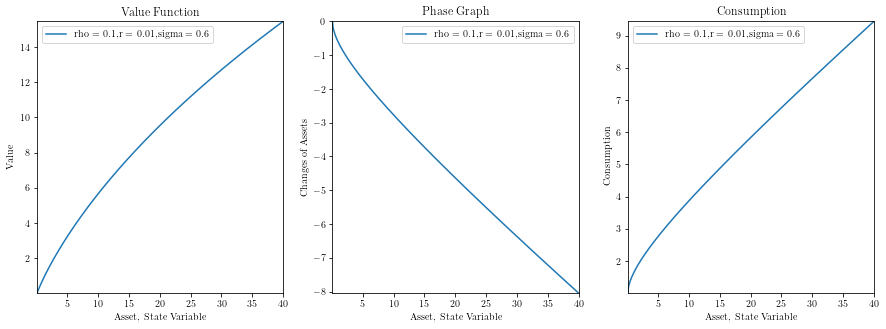

In [8]:
# Initilizing the parameters
rho = 0.1
r = 0.01
w = 1
sigma = 0.6


x_min = 0.1                             # The minimum value of asset
x_max = 40                             # The maximum (allowed) value of asset
x_h = 0.1                               # The width of each cell of the asset grid
num_x = int((x_max - x_min)/x_h) + 1    # The number of the asset grid's nodes 
x_grid = np.linspace(x_min, x_max, num_x, endpoint = True) # the gird is [0.1,0.2 ... 20], all 201 terms

# consumption path of numercial solution
cons = FDM_OS(x_grid=x_grid, rho = rho, r = r, w = w, sigma = sigma)[1]
v = FDM_OS(x_grid=x_grid, rho = rho, r = r, w = w, sigma = sigma)[0]
x_dot = r * x_grid + w - cons

# plot the value function

fig = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,3,1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(min(v), max(v))
    
plt.xlabel('Asset, State Variable')
plt.ylabel('Value')
plt.title('Value Function')


# plot the phase graph
    
ax2 = plt.subplot(1,3,2)   
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(min(x_dot), max(x_dot))
    
plt.xlabel('Asset, State Variable')
plt.ylabel('Changes of Assets')
plt.title('Phase Graph')

# plot the consumption
    
ax3 = plt.subplot(1,3,3)
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(min(cons), max(cons))
    
plt.xlabel('Asset, State Variable')
plt.ylabel('Consumption')
plt.title('Consumption')

ax1.plot(x_grid, v, label = 'rho = 0.1,r = 0.01,sigma = 0.6')
ax1.legend()
ax2.plot(x_grid, x_dot,  label = 'rho = 0.1,r = 0.01,sigma = 0.6')
ax2.legend()
ax3.plot(x_grid, cons, label = 'rho = 0.1,r = 0.01,sigma = 0.6')
ax3.legend()

plt.show()


7.6499999999999995
6.5024999999999995
5.527125
4.69805625
3.9933478124999997
3.3943456406249997
2.88519379453125
2.4524147253515625
2.084552516548828
1.7718696390665039
1.5060891932065283
1.280175814225549
373 -7.613678221256858 29.795251816116835 7.641860723746619
297 -6.333375180533395 23.461876635583437 6.494614217786146
234 -5.242720829284405 18.219155806299035 5.486363450396843
181 -4.31323611293582 13.905919693363217 4.651280038901184
138 -3.5206731395499045 10.38524655381331 3.9442754800068074
103 -2.844358766162811 7.540887787650499 3.354288210883856
75 -2.266639058994932 5.274248728655567 2.819724383242993
52 -1.7723623071258068 3.501886421529761 2.3604783431611907
34 -1.3484386933633972 2.1534477281663627 2.005737285455246
21 -0.9831694182000237 1.1702783099663399 1.663969834035359
11 -0.6655448771540061 0.5047334328123335 1.4351228445995798
5 -0.3823595139649477 0.12237391884738569 1.1410190209571713


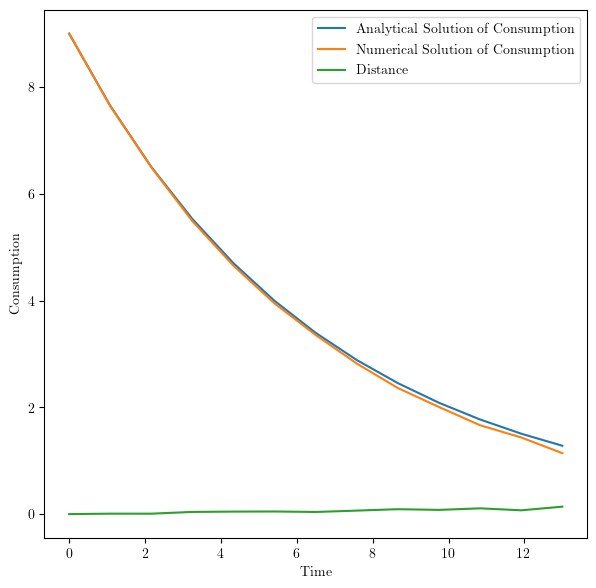

In [9]:
T = 12
t = np.linspace(0,T+1,T+1)
c0 = 9

# consumption path of analytical solution
k = ana_c(c0,T)

# consumption path of numerical solution
kj = numer_c(c0,T,cons, x_dot, x_grid)

# distance
distance = np.abs(k - kj)

fig = plt.figure(figsize = ([7,7]), dpi = 100)
ax = plt.subplot(111)
ax.plot(t,k, label = 'Analytical Solution of Consumption')
ax.plot(t,kj, label = 'Numerical Solution of Consumption')
ax.plot(t,distance, label = 'Distance')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

plt.show()

### Stochastic Situation with Poisson Process

----


In [11]:
##################################################################################
#
# Goal: 
#    This program aims to use Dynamic Programming to solve the Bellman Equation
#    of the Optimal Saving problem with Poisson Process. 
# Methodologies: 
#    Function Iteration,
#    Finite Difference Method with Upwind method,
# Details: 
#    The Bellman Function: rho*V = u(c) + (dV/da) (ra+w-c) + lambda*(V(1+beta)a)-V(a)) 
#    The Numerical Formula in Matrix form: (*)
#      [(1/Delta + \rho)I - A(n) + \lambda (Gamma(n)-I)] v(n+1) = u(n) + (1/Delta)v(n)
#      Delta: scaler, update step length
#      \rho: scaler, parameter
#      I: Identity matrix
#      A(n): coeffient matrix of dV/da, n-th iteration
#      Gamma(n): coeffient matrix of V((1+beta)a), n-th iteration
#      \lambda: scaler, Poisson parameter
#      u(n): vector of utility, n-th iteration
#      v(n): vector of value function, n-th iteration
#      
##################################################################################

########################################## Part 1: Function Defining ##########################################

## Utility Function
def Utility(c):
    
    '''
        utility function, given different consumption levels, give out the utility level
        Input:
            c: consumption, n * 1 vector (type: np.ndarray)
        Output:
            utility: utility, n * 1 vector (type: matrix)
    '''
    utility = np.zeros(c.size)
    utility = (c**(1-sigma)-1)/(1-sigma)
    utility = np.mat(utility).T
    
    return utility

########################################## Part 2: Upwind Derivative ##########################################

def upwind_d(x_grid,v):
    
    '''
        upwind derivative of given value function
        Inputs:
            x_gird: the gird of the asset levels, n * 1 vector (type: np.ndarray)
            v: the value function, n * 1 vector (type: np.ndarray)
        Output:
            u_c: utility, n * 1 vector (type: np.ndarray)
            f_x_f, f_x_b: forward, backward savings, n * 1 vector, (type: np.ndarray)
            cons: consumption, n * 1 vector, (type: np.ndarray)
            Dv_upwind: dV/da, n * 1 vector, (type: np.ndarray)
    '''
    
    V = v
    
   # Initialize the forward derivative, Dv_f, the backward derivative, Dv_b, the consumption level, c,

    num_x = len(x_grid)
    Dv_f = np.zeros(num_x)
    Dv_b = np.zeros(num_x)
    cons = np.zeros(num_x)
    
    # Update the forward, backward, stable state derivative of value function: dV/dx_f,dV/dx_b,dV/dx_ss, 
    
    for i in range(0, num_x-1):
        Dv_f[i] = (V[i+1] - V[i])/x_h  # calculate the forward derivative by linearization
        
    Dv_f[num_x-1] = 1/ (r*x_max + w)**sigma    # calculate the endpoint of forward derivative,
                                       # use the F.O.C.
                                       # assume the value is the steady state value
    
    for i in range(1, num_x):
        Dv_b[i] = (V[i] - V[i-1])/x_h  # calculate the backward derivative by linearization
        
    Dv_b[0] = 1/(r*x_min + w)**sigma   # calculate the endpoint of backward derivative,
                                       # use the F.O.C.
                                       # assume the value is the steady state value
    
    # Calculate the consumption, the critic condition, the corresponding f(x)
    
    cons_f = np.zeros(num_x)
    cons_f = Dv_f**(-1/sigma) 
                                      # use the F.O.C to calculate the consumption under the forward situation
    f_x_f = r * x_grid + w - cons_f   # calculate the f(x) under the forward situation
    
    cons_b = np.zeros(num_x)
    cons_b = (Dv_b)**(-1/sigma) 
                                      # use the F.O.C to calculate the consumption under the backward situation
    f_x_b = r * x_grid + w - cons_b   # calculate the f(x) under the backward situation    
    
    cons_ss = np.zeros(num_x)
    cons_ss = r * x_grid + w          # calculate the consumption under steady state
    Dv_ss = cons_ss**-sigma        # calculate the dV/dx under steady state

    # combining the dV/dx_f,_b,_ss to upwind dV/dx
    
    Dv_upwind = np.zeros(num_x)
    for i in range(0,num_x):
        weight = np.array([0,0,0])
        if f_x_f[i] > 0:
            weight[0] = 1
        
        if f_x_b[i] < 0:
            weight[1] = 1
        
        if weight[0] == 0 and weight[1]==0:
            weight[2] = 1
            
        Dv_upwind[i] = weight[0] * Dv_f[i] +weight[1] * Dv_b[i] + weight[2] * Dv_ss[i]
                    
    # Calculate the consumption and f(x) with upwind derivative of value function
    
    cons = Dv_upwind**(1/-sigma)

    u_c = np.zeros(num_x)
    u_c = (cons**(1-sigma)-1)/(1-sigma)
    
    return [u_c, f_x_f, f_x_b,cons, Dv_upwind]

##################################### Part 3: Iteration of Value Function #####################################

## Update the value function
def A_matrix(x_grid, v):
    '''
        Calculate the A matrix, which is the coefficient matrix before V
        A*V = the upwind derivative of V 
    '''
    
    num_x = len(x_grid)    
    x_h = (x_grid[-1]-x_grid[0])/(num_x-1)
    
    x_b = np.zeros((num_x,2))
    x_b[:,0] = upwind_d(x_grid, v)[2]
    x_f = np.zeros((num_x,2))
    x_f[:,0] = upwind_d(x_grid, v)[1] 
      
    X = -np.min(x_b,axis = 1 )/x_h                              
                        # 1st elements in the row vector
    Y = -np.max(x_f,axis = 1)/x_h + np.min(x_b, axis = 1)/x_h  
                        # 2nd element in the row vector
    Z = np.max(x_f,axis = 1)/x_h                                
                        # 3rd element in the row vector
    
    A = np.zeros((num_x, num_x))
    for i in range(1,num_x-1):
        A[i,i-1] = X[i]
        A[i,i] = Y[i]
        A[i,i+1] = Z[i]
        
    A[0,0]=Y[0]
    A[0,1]=Z[0]
    A[num_x-1,num_x-1] = Y[num_x-1]
    A[num_x-1,num_x-2] = X[num_x-1]
    
    return A

## Gamma matrix: V((1+beta)a) = Gamma * V(a)
def Gamma_matrix(x_grid, beta):
    '''
    Use the linear interpolation to approximate the V((1+beta)a)
    If (1+beta)a is an integer, then just take the value
    If (1+beta)a is NOT an integer, then 
                    V(a') = V(ceil(a'))(ceil(a')-a')+V(floor(a'))(a'-floor(a'))
    The output is a 'shear' matrix. It will be the coefficients of the vector
    of V(a)
        i.e.,  V((1+beta)a) = Gamma V(a)
    '''
    # prepare the empty matrix to fill in
    n = len(x_grid)
    dx = (x_grid[-1]-x_grid[0])/(n-1)
    Gamma = np.zeros([n,n])
    
    # generate the elements of interior points on matrix
    for i in range(n):
        x = x_grid[i]*(1+beta)
        if x <= x_grid[-1]:
            upper = np.argwhere(x_grid>=x)[0] 
                    # return the index of x on grid which is large than
                    # x(1+beta)
            lower = upper - 1
            prop_upper = (x_grid[upper]-x)/dx
            prop_lower = 1 - prop_upper
            Gamma[i,upper] = prop_lower
            Gamma[i,lower] = prop_upper
        else:    
            Dx = x - x_grid[-1]
            Gamma[i,-1] = Dx/dx + 1
            Gamma[i,-2] = -Dx/dx
    
    return Gamma

# One-step update
def update_v(x_grid, v, lambdax, beta):
    
    '''
        Solve the (*) Equation
    '''
    
    #Calculate the A matrix
    
    A = A_matrix(x_grid, v)
    Gamma = Gamma_matrix(x_grid, beta)
    
    # Set the length of step
    Delta = 1000
    
    # Calculate the LHS of (*), the coefficient of v^{n+1} 
    L = np.identity(num_x)
    L = (rho + 1/Delta) * L - A - lambdax * (Gamma - L)
    
    # Calculate the RHS of (*) 
    R = np.zeros(num_x)
    R = upwind_d(x_grid, v)[0] + v/Delta;
    
    # update the new value function
    v_new = np.zeros(num_x)
    v_new = np.linalg.inv(L).dot(R)
    
    v_delta = v_new - v
    v_delta = np.absolute(v_delta)
    v = v_new   
    return [v_delta, v, upwind_d(x_grid, v)[3], upwind_d(x_grid, v)[4]]


# Calculate the value function by iteration
def FDM_OS(x_grid, rho, r, w, sigma, lambdax, beta):
    
    '''
        Value function iteration
        Parameters:
            rho: subject discount rate, scaler
            r: interest rate, scaler
            w: wage, scaler
            sigma: CRRA parameter, scaler
        Inputs:
            x_gird: the gird of the asset levels, n * 1 vector (type: np.ndarray)     
        Outputs:
            v: value function, n * 1 vector (type: np.ndarray)
            cons: policy function, n * 1 vector (type: np.ndarray)
    '''

    ## Set the initial value function:
    
    num_x = len(x_grid)
    v = np.ones(num_x)   
    for i in range(0,num_x):
        v[i] = ((r*x_grid[i]+w)**(1-sigma)-1)/(1-sigma)           
        # assume the initial state is the steady state
        
    ## initial iteratin times and critical value
    itera = 0               # The iteration times
    metric_v = 100          # The metric between new and old value function
    
    # iteration
    while metric_v > 0.001:
        if itera < 5000:
            metric_v = np.max(update_v(x_grid, v, lambdax, beta)[0])
            v = update_v(x_grid, v, lambdax, beta)[1]
            itera = itera + 1
            print(itera, metric_v)
        else:
            break
            
#     Dv_Dx = np.zeros(num_x)
#     Dv_Dx = update_v(x_grid, v)[3]
    
#     cons = 1/Dv_Dx ** sigma  ! wrong formula
    cons = update_v(x_grid, v, lambdax, beta)[2]
    return [v, cons]

In [12]:
rho = 0.1
r = 0.01
w = 1
sigma = 0.6

x_min = 0.1                             # The minimum value of asset
x_max = 40                             # The maximum (allowed) value of asset
x_h = 0.1                               # The width of each cell of the asset grid
num_x = int((x_max - x_min)/x_h) + 1    # The number of the asset grid's nodes 
x_grid = np.linspace(x_min, x_max, num_x, endpoint = True) # the gird is [0.1,0.2 ... 20], all 201 terms

V1, c1 = FDM_OS(x_grid, rho, r, w, sigma, lambdax=0.05, beta=0.1)
V2, c2 = FDM_OS(x_grid, rho, r, w, sigma, lambdax=0, beta=0.1)
V3, c3 = FDM_OS(x_grid, rho, r, w, sigma, lambdax=0.05, beta=0)
V4, c4 = FDM_OS(x_grid, rho, r, w, sigma, lambdax=0, beta=0)



1 0.5106940402051535
2 1.1267623837678578
3 2.2970157352743543
4 3.8788198176748327
5 4.4919436487423
6 2.486922333295599
7 0.617720160665117
8 0.12920794043982653
9 0.021832289140016226
10 0.002531171201853588
11 9.258428151182052e-05
1 0.5105450485453141
2 1.1262657729096883
3 2.293705730918444
4 3.858760862173831
5 4.418892243187059
6 2.3979587512793525
7 0.5925549043434106
8 0.12329683080911114
9 0.020567357060780056
10 0.0023085241549749003
11 7.682219830179582e-05
1 0.5105450485453141
2 1.1262657729096883
3 2.293705730918444
4 3.858760862173831
5 4.418892243187059
6 2.3979587512793525
7 0.5925549043434106
8 0.12329683080911114
9 0.020567357060780056
10 0.0023085241549749003
11 7.682219830179582e-05
1 0.5105450485453141
2 1.1262657729096883
3 2.293705730918444
4 3.858760862173831
5 4.418892243187059
6 2.3979587512793525
7 0.5925549043434106
8 0.12329683080911114
9 0.020567357060780056
10 0.0023085241549749003
11 7.682219830179582e-05


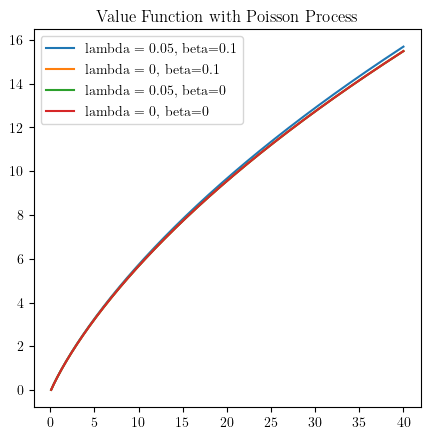

In [15]:
fig = plt.figure(figsize = [5,5], dpi = 100)
ax = plt.subplot(111)
ax.plot(x_grid, V1, label = 'lambda = 0.05, beta=0.1')
ax.plot(x_grid, V2, label = 'lambda = 0, beta=0.1')
ax.plot(x_grid, V3, label = 'lambda = 0.05, beta=0')
ax.plot(x_grid, V4, label = 'lambda = 0, beta=0')
plt.title('Value Function with Poisson Process')
plt.legend()
plt.show()